In [90]:
from urllib.parse import urlparse
import boto3
from io import BytesIO


class S3Url(object):
    """
    >>> s = S3Url("s3://bucket/hello/world")
    >>> s.bucket
    'bucket'
    >>> s.key
    'hello/world'
    >>> s.url
    's3://bucket/hello/world'

    >>> s = S3Url("s3://bucket/hello/world?qwe1=3#ddd")
    >>> s.bucket
    'bucket'
    >>> s.key
    'hello/world?qwe1=3#ddd'
    >>> s.url
    's3://bucket/hello/world?qwe1=3#ddd'

    >>> s = S3Url("s3://bucket/hello/world#foo?bar=2")
    >>> s.key
    'hello/world#foo?bar=2'
    >>> s.url
    's3://bucket/hello/world#foo?bar=2'
    """

    def __init__(self, url):
        self._parsed = urlparse(url, allow_fragments=False)

    @property
    def bucket(self):
        return self._parsed.netloc

    @property
    def key(self):
        if self._parsed.query:
            return self._parsed.path.lstrip('/') + '?' + self._parsed.query
        else:
            return self._parsed.path.lstrip('/')

    @property
    def url(self):
        return self._parsed.geturl()

session = boto3.Session(profile_name='default')
client = session.client("s3", region_name="us-east-1")

def image_from_s3(url):
    s3_url = S3Url(url)
    resp = client.get_object(Bucket=s3_url.bucket, Key=s3_url.key)
    raw = resp.get('Body').read()
    return Image.open(BytesIO(raw))


In [115]:
import torchvision
import os


class S3Coco(torchvision.datasets.CocoDetection):
    def __init__(self, ann_file):
        super(S3Coco, self).__init__("", ann_file)
        self.processor = processor

    def _load_image(self, id):
        path = self.coco.loadImgs(id)[0]["file_name"]
        # return Image.open(os.path.join(self.root, path)).convert("RGB")
        return image_from_s3(path).convert("RGB")

In [177]:
import json
import os
from urllib.parse import urlparse

coco_image = {
	"width": int,
	"height": int,
	"id": int,
	"file_name": str
}
coco_annotation = {
	"image_id": int,
	"bbox": list[float],
	"category_id": int,
	"segmentation": list[float],
	"area": float,
	"iscrowd": int,
	"id": int
}
large_coco = json.load(open('datasets/result.json'))
coco_images: list[coco_image] = large_coco['images']
image_id_seq = 0
annotation_id_seq = 0
small_images: list[coco_image] = []
small_annotations: list[coco_annotation] = []


for coco_img in coco_images:
	annotations: list[coco_annotation] = list(filter(lambda ann: ann["image_id"] == coco_img["id"], large_coco['annotations']))
	if len(annotations) == 0:
		continue
	image = image_from_s3(coco_img['file_name'])
	split_images = split_image_with_labels(image=image, labels=annotations, 
															  hint_size_min=(500,500), hint_size_max=(1000,1000), 
															  overlap=0.1)
	for small in split_images:
		image_id_seq += 1
		image_id = image_id_seq
		left, top, _, _ = small["area"]
		url = urlparse(coco_img['file_name'], allow_fragments=False)
		file_name = url.path.split('/')[-1]
		file_name, file_extension = os.path.splitext(file_name)
		file_name = f"{file_name}_({left},{top}){file_extension}"
		small["image"].save(f"datasets/small/{file_name}")
		small_images.append({
			"width": small["image"].width,
			"height": small["image"].height,
			"id": image_id,
			"file_name": f"datasets/small/{file_name}"
		})
		for ann in small["labels"]:
			annotation_id_seq += 1
			small_annotations.append({
				"image_id": image_id,
				"bbox": ann["bbox"],
				"category_id": ann["category_id"],
				"segmentation": ann["segmentation"],
				"area": ann["bbox"][2] * ann["bbox"][3],
				"iscrowd": ann["iscrowd"],
				"id": annotation_id_seq
			})
large_coco['images'] = small_images
large_coco['annotations'] = small_annotations
json.dump(large_coco, open('datasets/small.json', 'w'))

In [178]:
import torchvision
import os


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, processor):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [179]:
from transformers import DetrImageProcessor
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

coco = CocoDetection(img_folder='.', ann_file='datasets/small.json', processor=processor)
train_ratio = 0.8
train_size = int(train_ratio * len(coco))
val_size = len(coco) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(coco, [train_size, val_size])

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [180]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 4188
Number of validation examples: 1048


Image n°3881
2


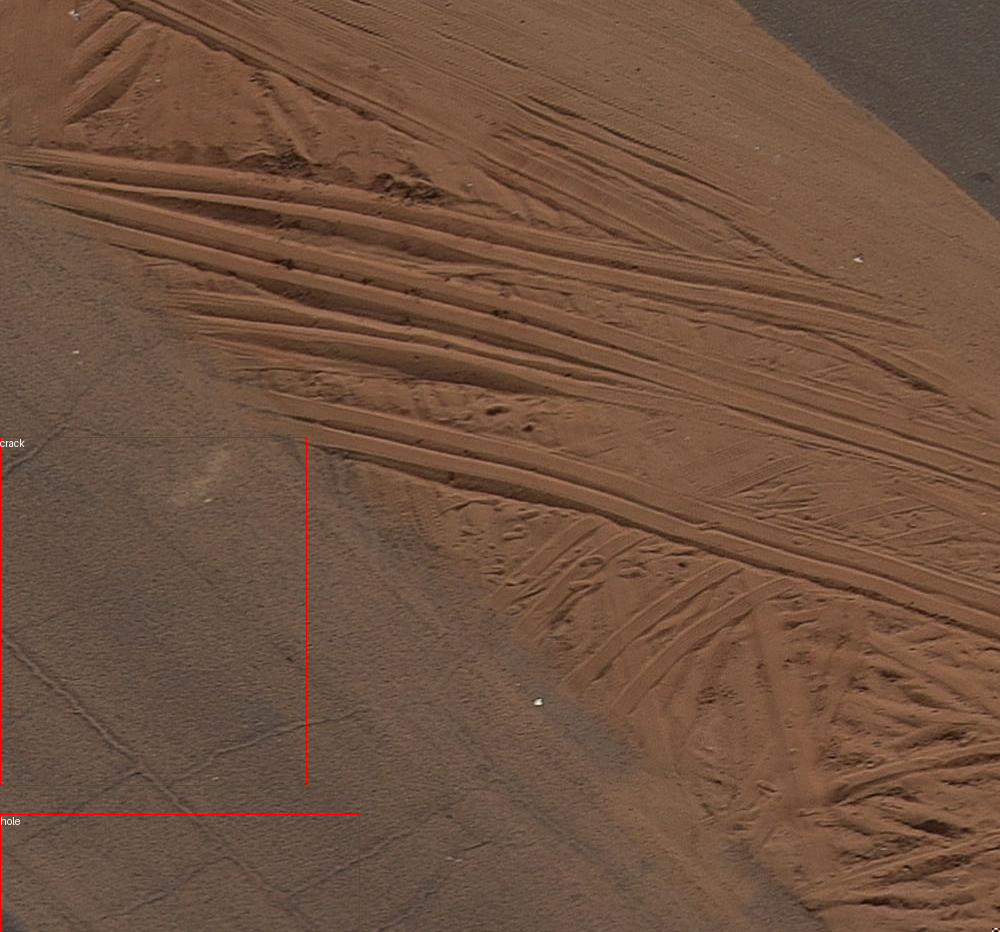

In [182]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = coco.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = coco.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(image['file_name']))

annotations = coco.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = coco.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [183]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

In [184]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [185]:
pixel_values, target = train_dataset[0]

In [186]:
pixel_values.shape

torch.Size([3, 800, 858])

In [187]:
print(target)

{'size': tensor([800, 858]), 'image_id': tensor([4880]), 'class_labels': tensor([], dtype=torch.int64), 'boxes': tensor([], size=(0, 4)), 'area': tensor([]), 'iscrowd': tensor([], dtype=torch.int64), 'orig_size': tensor([ 932, 1000])}


In [188]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch

class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [189]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 69958), started 19:46:25 ago. (Use '!kill 69958' to kill it.)

In [203]:
model = Detr(lr=1e-6, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([17, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([17]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [191]:
outputs.logits.shape

torch.Size([4, 100, 17])

In [204]:
from pytorch_lightning import Trainer

trainer = Trainer(max_steps=300, gradient_clip_val=0.1)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
18.1 M    Trainable params
23.5 M    Non-trainable params
41.5 M    Total params
166.022   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/Users/famer.me/Repository/detr-playground/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
